In [1]:
%load_ext autoreload
dp["output"] = model.fc(torch.tensor(data_dp["emb"].data).to(torch.float))


In [2]:
from domino.slices import collect_settings
import meerkat as mk
from domino.slices.celeba import CelebASliceBuilder
from domino.evaluate import run_sdm, score_sdms, run_sdms
from domino.train import train_settings, score_settings, score_model
import numpy as np
import pandas as pd
import terra
import seaborn as sns
from domino.emb.clip import embed_phrases
import matplotlib.pyplot as plt 

/home/sabri/code/meerkat/meerkat/nn/__init__.py:7: ExperimentalWarning: The `meerkat.nn` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


In [10]:
from domino.slices import build_setting
dp = build_setting(**build_setting.inp(run_id=60737)).load()
dp = dp.lz[dp["split"] == "test"]

cache hit –> task: build_setting, run_id=60737


In [64]:
run_df = train_settings.get_runs()
run_ids = run_df[
    (run_df["status"] == "success")
    & (run_df["hostname"].str.startswith("script-mimic-worker"))
]["id"][:8]
print(list(run_ids))


[69628, 69611, 69606, 69599, 69588, 69581]


In [52]:
terra.out(run_id=64281).load()

,alpha (NumpyArrayColumn),build_setting_kwargs (ListColumn),dataset (PandasSeriesColumn),slice_category (PandasSeriesColumn),slice_names (ListColumn),target_name (PandasSeriesColumn),index (PandasSeriesColumn),setting_id (PandasSeriesColumn)
0,0.2,"{'n': 30000, 'correlate': 'eyeglasses', 'target': 'bald', 'corr': 0.2}",celeba,correlation,"['bald=0_eyeglasses=1', 'bald=1_eyeglasses=0']",bald,0,11c7c98d-9fee-4092-ba30-656cd02519c9
1,0.4,"{'n': 30000, 'correlate': 'eyeglasses', 'target': 'bald', 'corr': 0.4}",celeba,correlation,"['bald=0_eyeglasses=1', 'bald=1_eyeglasses=0']",bald,1,07b08723-d5e6-4a8f-aaf1-95e3bd7e506c
2,0.6,"{'n': 30000, 'correlate': 'eyeglasses', 'target': 'bald', 'corr': 0.6000000000000001}",celeba,correlation,"['bald=0_eyeglasses=1', 'bald=1_eyeglasses=0']",bald,2,e9903671-2916-4260-be23-21f40cff4956
3,0.8,"{'n': 30000, 'correlate': 'eyeglasses', 'target': 'bald', 'corr': 0.8}",celeba,correlation,"['bald=0_eyeglasses=1', 'bald=1_eyeglasses=0']",bald,3,610cd06c-ba58-4d31-a650-06fcdbb8dc5a
4,0.2,"{'n': 30000, 'correlate': 'gray_hair', 'target': 'bald', 'corr': 0.2}",celeba,correlation,"['bald=0_gray_hair=1', 'bald=1_gray_hair=0']",bald,4,f1b393d1-de62-485e-98a7-a326ff4537f9
...,...,...,...,...,...,...,...,...
515,0.8,"{'n': 30000, 'correlate': 'wearing_necklace', 'target': 'young', 'corr': 0.8}",celeba,correlation,"['young=0_wearing_necklace=1', 'young=1_wearing_necklace=0']",young,515,6be6e6eb-5e9e-4fbb-b572-ba9196266c95
516,0.2,"{'n': 30000, 'correlate': 'wearing_necktie', 'target': 'young', 'corr': 0.2}",celeba,correlation,"['young=0_wearing_necktie=1', 'young=1_wearing_necktie=0']",young,516,db31724a-77cc-4719-83ea-94b416ea52fe
517,0.4,"{'n': 30000, 'correlate': 'wearing_necktie', 'target': 'young', 'corr': 0.4}",celeba,correlation,"['young=0_wearing_necktie=1', 'young=1_wearing_necktie=0']",young,517,e6372a66-945f-4f51-ba2c-f75d4da2ef08
518,0.6,"{'n': 30000, 'correlate': 'wearing_necktie', 'target': 'young', 'corr': 0.6000000000000001}",celeba,correlation,"['young=0_wearing_necktie=1', 'young=1_wearing_necktie=0']",young,518,534b1827-bd7d-43b3-8435-f9d1671db914


In [42]:
train_settings.inp()

{'setting_dp': Artifact(id=433119, run_id=56417, type=<class 'meerkat.datapanel.DataPanel'>),
 'data_dp': Artifact(id=231038, run_id=19189, type=<class 'meerkat.datapanel.DataPanel'>),
 'split_dp': Artifact(id=231039, run_id=19190, type=<class 'meerkat.datapanel.DataPanel'>),
 'model_config': {'pretrained': False},
 'continue_run_ids': [56437, 56436, 56427, 56418],
 'num_samples': 1,
 'num_gpus': 1,
 'num_cpus': 8,
 'run_dir': None,
 'batch_size': 256,
 'check_val_every_n_epoch': 2,
 'max_epochs': 10,
 'ckpt_monitor': 'valid_auroc',
 'worker_idx': 0,
 'num_workers': 8}

In [73]:

train_settings.inp(70212)

{'setting_dp': Artifact(id=521473, run_id=70212, type=<class 'meerkat.datapanel.DataPanel'>),
 'data_dp': Artifact(id=432944, run_id=56388, type=<class 'meerkat.datapanel.DataPanel'>),
 'split_dp': Artifact(id=432945, run_id=56389, type=<class 'meerkat.datapanel.DataPanel'>),
 'model_config': {},
 'num_gpus': 4,
 'num_cpus': 16,
 'num_samples': 1,
 'continue_run_ids': None,
 'run_dir': None,
 'batch_size': 256,
 'val_check_interval': 50,
 'max_epochs': 10,
 'ckpt_monitor': 'valid_auroc',
 'worker_idx': 0,
 'num_workers': 8}

In [74]:
train_settings.inp(72261)

{'setting_dp': Artifact(id=537518, run_id=72261, type=<class 'meerkat.datapanel.DataPanel'>),
 'data_dp': Artifact(id=432944, run_id=56388, type=<class 'meerkat.datapanel.DataPanel'>),
 'split_dp': Artifact(id=432945, run_id=56389, type=<class 'meerkat.datapanel.DataPanel'>),
 'model_config': {},
 'num_gpus': 4,
 'num_cpus': 16,
 'num_samples': 1,
 'continue_run_ids': None,
 'run_dir': None,
 'batch_size': 256,
 'val_check_interval': 50,
 'max_epochs': 10,
 'ckpt_monitor': 'valid_auroc',
 'worker_idx': 0,
 'num_workers': 8}

In [29]:
run_ids = [60907, 60898, 60897, 60880, 60851, 60850, 60845, 60840]
dp["output"] = model.fc(torch.tensor(data_dp["emb"].data).to(torch.float))
score_model_run_ids = mk.concat(
    [score_settings.out(run_id)[0].load()["score_model_run_id"] for run_id in run_ids]
)
for score_model_run_id in score_model_run_ids:
    metrics = score_model.out(score_model_run_id)[1]
    if metrics["out_slice_recall_lower"] > metrics["in_slice_0_recall_upper"] + 0.05:
        rows.append({
            "score_model_run_id": score_model_run_id,
            "gap": metrics["out_slice_recall_lower"] - metrics["in_slice_0_recall_upper"]
        } )
under_df = pd.DataFrame(rows)

In [100]:
#run_ids = [37943, 37491, 36681]
#dp["output"] = model.fc(torch.tensor(data_dp["emb"].data).to(torch.float))
#run_ids = [62833, 62832, 62773, 62740, 62301, 62245, 62196, 61869]
run_ids = [68523]
#run_ids = run_df[run_df["hostname"].str.startswith("script-imagenet-worker")]["id"][:5].values
score_df = pd.concat([score_sdms.out(run_id).load() for run_id in run_ids])
score_df = score_df.fillna(0)

In [101]:
plot_df = score_df.iloc[
    score_df.groupby(["target_name", "slice_name", "slice_idx", "emb_group", "alpha", "sdm_class"])["precision_at_10"]
    .idxmax()
    .astype(int)
].copy()
#plot_df = plot_df[plot_df["score_model_run_id"].isin(under_df["score_model_run_id"])]
plot_df["success"] = plot_df["precision_at_10"] > 0.8

[2021-10-01 20:00:26,108][WARNING][matplotlib.legend:1225] :: No handles with labels found to put in legend.


<Figure size 144x144 with 0 Axes>

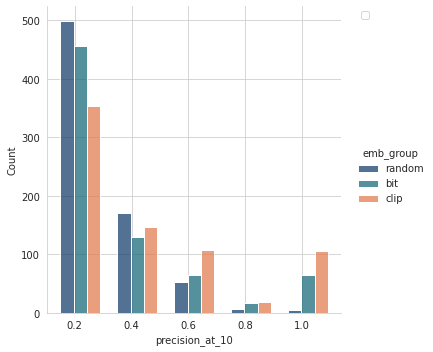

In [139]:
from transformers import pipeline, set_seed
from domino.plot import *

plt.figure(figsize=(2,20))
plt.tight_layout()
sns.displot(
    data=plot_df[plot_df["sdm_class"] == "domino.sdm.gmm.MixtureModelSDM"],
    x="precision_at_10",
    hue="emb_group",
    multiple="dodge",
    bins=5,
    shrink=0.7,
    hue_order=EMB_PALETTE.keys(),
    palette=sns.color_palette(EMB_PALETTE.values(), 3)
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.savefig("figures/08-01_dist.pdf")


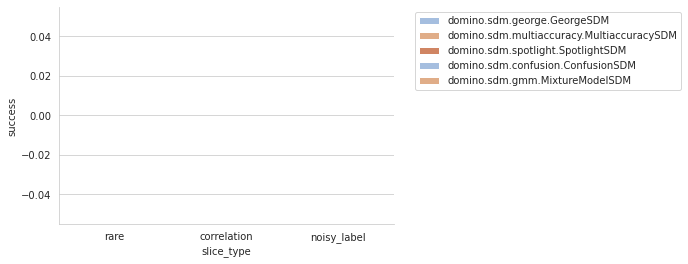

In [133]:
from transformers import pipeline, set_seed
from domino.plot import *

df = []
for slice_type in ["rare", "correlation", "noisy_label"]:
    curr_df = plot_df.copy()
    curr_df["slice_type"] = slice_type
    df.append(curr_df)
df = pd.concat(df)

sns.set_style("whitegrid")

sns.barplot(
    data=df[df["sdm_class"] == "domino.sdm.gmm.MixtureModelSDM"],
    y="success",
    x="slice_type",
    hue="emb_group",
    hue_order=EMB_PALETTE.keys(),
    palette=sns.color_palette(EMB_PALETTE.values(), 3)
)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.savefig("figures/08-01_dist.pdf")


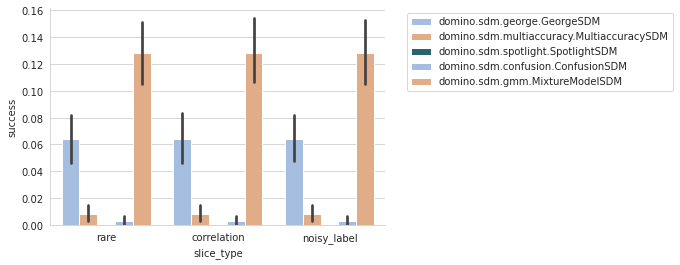

In [135]:
from transformers import pipeline, set_seed
from domino.plot import *

df = []
for slice_type in ["rare", "correlation", "noisy_label"]:
    curr_df = plot_df.copy()
    curr_df["slice_type"] = slice_type
    df.append(curr_df)
df = pd.concat(df)

sns.set_style("whitegrid")

sns.barplot(
    data=df[df["emb_group"] == "clip"],
    y="success",
    x="slice_type",
    hue="sdm_class",
    hue_order=SDM_PALETTE.keys(),
    palette=sns.color_palette(SDM_PALETTE.values(), 3)
)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.savefig("figures/08-01_bar.pdf")


In [76]:
under_df

,score_model_run_id,gap
0,49433,0.280557
1,49514,0.178780
2,49517,0.171784
3,49538,0.192575
4,49585,0.116570
5,49607,0.154800
6,49397,0.175421
7,49398,0.252200
8,49421,0.146164
9,49434,0.425186


In [9]:
score_settings.out().load()["score_model_run_id"]
data_dp, emb_dp = inp["data_dp"], inp["emb_dp"]

data_dp = data_dp.lz[data_dp["split"].isin(["valid", "test"])].merge(
    emb_dp[["image_id", "emb"]], on="image_id"
)
slice_idx = 0
inp["slice_names"][slice_idx]

'orange.n.01'

In [10]:
score_settings.out().load()["score_model_run_id"]
# sdm = MixtureModelSDM(
#     n_slices=5, 
#     n_clusters=25, 
#     weight_y_log_likelihood=10, 
#     init_params="error",
#     emb="emb",
#     n_components=128 
# )
sdm = SupervisedSDM(dict(emb="emb"))
sdm.fit(data_dp.lz[data_dp["split"] == "valid"])
dp = sdm.transform(data_dp.lz[data_dp["split"] == "test"])

In [11]:
score_settings.out().load()["score_model_run_id"]

metrics_df = compute_sdm_metrics(dp)
metrics_df[metrics_df["slice_idx"] == slice_idx].sort_values(
    by="auroc", ascending=False
)


/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/common/envs/conda/envs/domino/lib/python3.8/site-

,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,recall,precision
1,1,0,0.500000,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.000000
2,2,0,0.500000,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.000000
3,3,0,0.500000,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.000000
4,4,0,0.500000,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.000000
0,0,0,0.470456,0.0,0.04,0.03,0.021053,0.031579,0.042105,1.0,0.015325


In [16]:
score_settings.out().load()["score_model_run_id"]
import torch

model = models.resnet18(pretrained=True)

In [22]:
type(synthetic_score_settings.out().load())
dp["output"] = model.fc(torch.tensor(data_dp["emb"].data).to(torch.float))

In [23]:
type(synthetic_score_settings.out().load())
probs = torch.nn.functional.softmax(probs, dim=0)

with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

dp["preds"] = list(map(lambda x: categories[x], probs.argmax(dim=1)))

,image_id (PandasSeriesColumn),path (PandasSeriesColumn),index (PandasSeriesColumn),image (ImageColumn),name (PandasSeriesColumn),synset_pos_offset (PandasSeriesColumn),synset (PandasSeriesColumn),target (NumpyArrayColumn),slices (NumpyArrayColumn),input (ImageColumn),id (PandasSeriesColumn),split (PandasSeriesColumn),probs (TensorColumn),emb (NumpyArrayColumn),output (TensorColumn),preds (PandasSeriesColumn)
0,n07742313_4539,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07742313/n07742313_4539.JPEG,1214614,,Granny Smith,n07742313,granny_smith.n.01,1.0,"np.ndarray(shape=(1,))",,n07742313_4539,valid,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",torch.Tensor(shape=torch.Size([1000])),Band Aid
1,n04152593_6652,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n04152593/n04152593_6652.JPEG,1002798,,"screen, CRT screen",n04152593,screen.n.03,0.0,"np.ndarray(shape=(1,))",,n04152593_6652,test,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",torch.Tensor(shape=torch.Size([1000])),fire screen
2,n07768694_3011,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07768694/n07768694_3011.JPEG,1225975,,pomegranate,n07768694,pomegranate.n.02,1.0,"np.ndarray(shape=(1,))",,n07768694_3011,test,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",torch.Tensor(shape=torch.Size([1000])),bassoon
3,n07745940_10395,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07745940/n07745940_10395.JPEG,1215002,,strawberry,n07745940,strawberry.n.01,1.0,"np.ndarray(shape=(1,))",,n07745940_10395,test,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",torch.Tensor(shape=torch.Size([1000])),Norfolk terrier
4,n02965783_3305,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n02965783/n02965783_3305.JPEG,610715,,car mirror,n02965783,car_mirror.n.01,0.0,"np.ndarray(shape=(1,))",,n02965783_3305,test,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",torch.Tensor(shape=torch.Size([1000])),lumbermill
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9133,n02172182_12974,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n02172182/n02172182_12974.JPEG,390325,,dung beetle,n02172182,dung_beetle.n.01,0.0,"np.ndarray(shape=(1,))",,n02172182_12974,test,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",torch.Tensor(shape=torch.Size([1000])),pot
9134,n07768694_9926,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n07768694/n07768694_9926.JPEG,1226665,,pomegranate,n07768694,pomegranate.n.02,1.0,"np.ndarray(shape=(1,))",,n07768694_9926,valid,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",torch.Tensor(shape=torch.Size([1000])),strainer
9135,n02111500_880,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n02111500/n02111500_880.JPEG,329739,,Great Pyrenees,n02111500,great_pyrenees.n.01,0.0,"np.ndarray(shape=(1,))",,n02111500_880,test,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",torch.Tensor(shape=torch.Size([1000])),dam
9136,n02490219_1636,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n02490219/n02490219_1636.JPEG,483864,,marmoset,n02490219,marmoset.n.01,0.0,"np.ndarray(shape=(1,))",,n02490219_1636,valid,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",torch.Tensor(shape=torch.Size([1000])),lorikeet

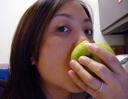
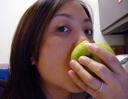
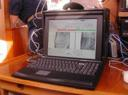
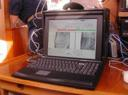
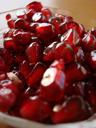
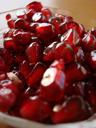
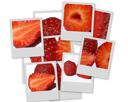
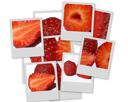
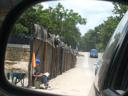
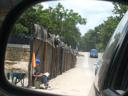
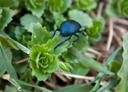
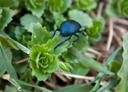
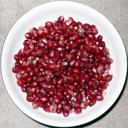
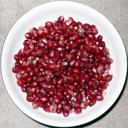
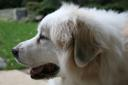
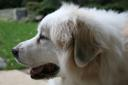
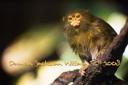
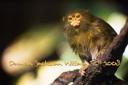
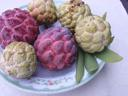
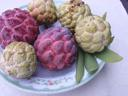

In [24]:
type(synthetic_score_settings.out().load())


In [28]:
type(synthetic_score_settings.out().load())
words_dp = words_dp[:10_000]

pred_slice_idx = 0
words_dp = words_dp.view()
pred_slice = dp["pred_slices"][:, pred_slice_idx]
slice_proto = dp.lz[pred_slice.argsort()[-10:]]["emb"].mean(axis=0)
ref_proto = dp["emb"][dp["target"] == 0].data.mean(axis=0)

words_dp["pred_slices"] = np.dot(
    words_dp["emb"].data, (slice_proto - ref_proto).T
)
expl_dp = words_dp[["word", "pred_slices"]]
expl_dp.lz[(-expl_dp["pred_slices"]).argsort()[0:5]]

,word (PandasSeriesColumn),pred_slices (NumpyArrayColumn)
0,a photo of a woman with blonde hair.,5.128906
1,a photo of a girl with blonde hair.,4.894531
2,a photo of a blonde woman,4.871094
3,a photo of a blonde girl,4.726562
4,a germanic photo of a woman,4.554688


,image (ImageColumn),target (NumpyArrayColumn),correlate (NumpyArrayColumn)
0,,0,1
1,,0,1
2,,0,1
3,,0,1
4,,0,1

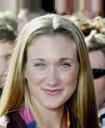
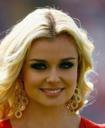
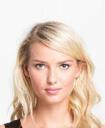
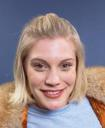
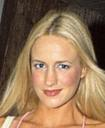

In [29]:

dp.lz[dp["pred_slices"].data[:, pred_slice_idx].argsort()[-5:]][["image", "target", "correlate"]]

In [5]:
dp


,(PandasSeriesColumn)
0,15006
1,15007
2,15008
3,15005
4,15009
5,15010
6,15011
7,15012
8,15014
9,15013


In [8]:
dp


In [18]:
from sklearn.metrics import roc_auc_score

nltk.download("wordnet")
roc_auc_score(score_dp.lz[mask]["target"], score_dp.lz[mask]["probs"][:, 1])

0.26252927075972343

In [13]:
score_dp["probs"] = score_dp["output"].probabilities()

In [10]:
from domino.train import score_settings, synthetic_score_settings, score_model

In [5]:
from transformers import pipeline, set_seed


meerkat.datapanel.DataPanel

In [19]:
from transformers import pipeline, set_seed


,train_model_run_id (PandasSeriesColumn),setting_id (NumpyArrayColumn),corr (NumpyArrayColumn),correlate (PandasSeriesColumn),dataset (PandasSeriesColumn),n (NumpyArrayColumn),slice_category (PandasSeriesColumn),target (PandasSeriesColumn),index (PandasSeriesColumn),parent_run_id (PandasSeriesColumn),build_setting_run_id (PandasSeriesColumn),time_this_iter_s (PandasSeriesColumn),done (PandasSeriesColumn),timesteps_total (PandasSeriesColumn),episodes_total (PandasSeriesColumn),training_iteration (PandasSeriesColumn),experiment_id (PandasSeriesColumn),date (PandasSeriesColumn),timestamp (PandasSeriesColumn),time_total_s (PandasSeriesColumn),pid (PandasSeriesColumn),hostname (PandasSeriesColumn),node_ip (PandasSeriesColumn),time_since_restore (PandasSeriesColumn),timesteps_since_restore (PandasSeriesColumn),iterations_since_restore (PandasSeriesColumn),trial_id (PandasSeriesColumn),config/corr (PandasSeriesColumn),config/correlate (PandasSeriesColumn),config/dataset (PandasSeriesColumn),config/index (PandasSeriesColumn),config/n (PandasSeriesColumn),config/setting_id (PandasSeriesColumn),config/slice_category (PandasSeriesColumn),config/target (PandasSeriesColumn),logdir (PandasSeriesColumn),score_settings_run_id (PandasSeriesColumn),score_model_run_id (PandasSeriesColumn),synthetic_preds (PandasSeriesColumn)
0,14936,163,0.6,blond_hair,celeba,30000,correlation,wearing_necklace,0,14928,14930,1112.037066,False,NaN,NaN,1,8ef98aebaa294f1f8875ae337af348ea,2021-09-22_12-08-35,1632312515,1112.037066,198,run-script-nf5ts,10.92.1.25,1112.037066,0,1,36c4b_00000,0.6,blond_hair,celeba,163,30000,163,correlation,wearing_necklace,"/root/ray_results/_train_model_2021-09-22_11-49-59/_train_model_36c4b_00000_0_config={'corr': 0.6000000000000001, 'correlate': 'blond_hair', 'dataset': 'celeba', 'n': 30000, 'slice__2021-09-22_11-49-59",15044,15045,False
1,14933,139,0.8,eyeglasses,celeba,30000,correlation,wearing_hat,1,14928,14931,1116.230135,False,NaN,NaN,1,20a0c9441e584990983fc829547b6915,2021-09-22_12-08-39,1632312519,1116.230135,196,run-script-nf5ts,10.92.1.25,1116.230135,0,1,36c4b_00001,0.8,eyeglasses,celeba,139,30000,139,correlation,wearing_hat,"/root/ray_results/_train_model_2021-09-22_11-49-59/_train_model_36c4b_00001_1_config={'corr': 0.8, 'correlate': 'eyeglasses', 'dataset': 'celeba', 'n': 30000, 'slice_category': 'cor_2021-09-22_11-49-59",15044,15046,False


In [24]:
score_model.out(15045)[0].load()["split"].unique()

array(['train', 'valid'], dtype=object)

In [56]:
from domino.data.celeba import get_celeba_dp

In [96]:
from transformers import pipeline, set_seed
out = sb.build_rare_setting(
    data_dp=get_celeba_dp.out().load(),
    target_attrs=["wearing_earrings", "male", "blond_hair"],
    slice_attrs=["blond_hair"],
    slice_frac=0.01,
    target_frac=0.5,
    n=20_000
)

In [99]:
from transformers import pipeline, set_seed


0.1394

In [84]:
from transformers import pipeline, set_seed


0.7881282730911802

In [73]:
unmasker = pipeline("fill-mask", model="xlm-roberta-base")


In [85]:
unmasker = pipeline("", max_length=30, num_return_sequences=5)

targets = np.array(
            [data_dp[attr] for attr in target_attrs]
)


In [100]:
unmasker = pipeline("", max_length=30, num_return_sequences=5)


NameError: name 'train_settings' is not defined

In [97]:
unmasker = pipeline("", max_length=30, num_return_sequences=5)
dp = get_wiki_words(top_k=10_000, eng_only=True).load()
(dp["word"] == "earrings").any()

task: get_wiki_words, run_id=16792


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


False

In [98]:
unmasker = pipeline("", max_length=30, num_return_sequences=5)


,word (PandasSeriesColumn),frequency (PandasSeriesColumn),index (PandasSeriesColumn)
0,the,151983633.0,0
1,of,71874676.0,1
2,and,62210193.0,2
3,in,62004799.0,3
4,to,43364193.0,4
...,...,...,...
9995,het,5533.0,9995
9996,cleric,5531.0,9996
9997,unfavorable,5528.0,9997
9998,disperse,5528.0,9998


In [104]:
"blond" in dp["word"]

False

In [5]:
import nltk
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
from nltk.corpus import wordnet as wn
nl

In [71]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("A portrait of a person", max_length=7, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'A portrait of a person who died'},
 {'generated_text': "A portrait of a person's head"},
 {'generated_text': 'A portrait of a person holding down'},
 {'generated_text': 'A portrait of a person who will'},
 {'generated_text': 'A portrait of a person wearing long'}]

In [17]:
dp.sort_values("prob")
for hypernym in synset.closure(lambda s: s.hypernyms()):
    hypernyms.append(
        {
            "synset": synset.name(),
            "hypernym": hypernym.name(),
        }
    )
hypernyms

[{'synset': 'smile.n.01', 'hypernym': 'facial_expression.n.01'},
 {'synset': 'smile.n.01', 'hypernym': 'gesture.n.02'},
 {'synset': 'smile.n.01', 'hypernym': 'visual_communication.n.01'},
 {'synset': 'smile.n.01', 'hypernym': 'communication.n.02'},
 {'synset': 'smile.n.01', 'hypernym': 'abstraction.n.06'},
 {'synset': 'smile.n.01', 'hypernym': 'entity.n.01'}]

In [27]:
dp.sort_values("prob")


In [28]:
dp.sort_values("prob")


In [26]:
phrase_dp.to_pandas().sort_values("prob").iloc[-15:]


PipelineException: No mask_token (<mask>) found on the input

In [ ]:
phrase_dp.to_pandas().sort_values("prob").iloc[-15:]


In [41]:
unmasker(f"A photo of a person .")

[{'sequence': 'A photo of a person, smiling.',
  'score': 0.40710172057151794,
  'token': 4,
  'token_str': ','},
 {'sequence': 'A photo of a person while smiling.',
  'score': 0.08363543450832367,
  'token': 12960,
  'token_str': 'while'},
 {'sequence': 'A photo of a person still smiling.',
  'score': 0.0663875937461853,
  'token': 7464,
  'token_str': 'still'},
 {'sequence': 'A photo of a person not smiling.',
  'score': 0.025921307504177094,
  'token': 959,
  'token_str': 'not'},
 {'sequence': 'A photo of a person is smiling.',
  'score': 0.0218026302754879,
  'token': 83,
  'token_str': 'is'}]

In [3]:
log = run_sdms.get_log()
    "a photo of a person {}",
    "a photo of a person {} [MASK]",
    "a photo of a person {} [MASK] [MASK]",
    "a photo of a person [MASK] {}",
    "a photo of a person [MASK] {} [MASK]",
    "a photo of a person [MASK] {} [MASK][MASK]",
    "a photo of a person [MASK] [MASK] {}",
    "a photo of a person [MASK] [MASK] {} [MASK]",
    "a photo of a person [MASK] [MASK] {} [MASK] [MASK]",
]

In [68]:
log = run_sdms.get_log()
from transformers import BertTokenizer, BertModel,BertForMaskedLM
 
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')

word = "smiling"
input_txt = [template.format(word) for template in templates]

inputs = tokenizer(input_txt, return_tensors='pt', padding=True).to(0)


model = BertForMaskedLM.from_pretrained('bert-large-cased').to(0)

outputs = model(**inputs)
predictions = outputs
# sorted_preds, sorted_idx = predictions[0].sort(dim=-1, descending=True)
# for k in range(10):
#     predicted_index = [sorted_idx[i, k if inputs["input_ids"][1, i] == 103 else 0].item() for i in range(0, inputs["input_ids"].shape[-1])]
#     predicted_token = [tokenizer.convert_ids_to_tokens([predicted_index[x]])[0] for x in range(1,inputs["input_ids"].shape[-1])]
#     print(predicted_token)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [54]:
sorted_preds, sorted_ids = predictions.logits.sort(dim=-1, descending=True)

In [62]:
log.find("end of loop")


torch.Size([9, 12, 28996])

In [66]:
input_ids = inputs["input_ids"]
for rank in range(10):
    curr_ids = sorted_ids[:, :, rank]
    curr_ids[input_ids != 103] = input_ids[input_ids != 103]
    for sent_idx in range(sorted_ids.shape[0]):

        candidate_df.append(
            {
                "text": tokenizer.decode(
                    sorted_ids[sent_idx, :, rank], skip_special_tokens=True
                ),
                "prob": sorted_preds[sent_idx, :, rank].mean().cpu().detach().numpy(),
            }
        )
candidate_df = pd.DataFrame(candidate_df)

In [67]:
log.find("end of loop")


,text,prob
89,a photo of a person - ; smiling widely and,7.0040717
86,a photo of a person standing smiling now and,7.0434494
88,a photo of a person with while smiling -,7.0881395
87,a photo of a person crying - smiling,7.1516395
80,"a photo of a person'- smiling eyes """,7.2351427
...,...,...
7,"a photo of a person, and smiling.",14.271441
4,"a photo of a person, smiling ;",14.699389
2,a photo of a person smiling broadly ;,14.843798
0,a photo of a person smiling,15.80104


In [56]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np 

gpt_model = GPT2LMHeadModel.from_pretrained('gpt2').to(0)
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

scores = []
for text in sents:
    tokens_tensor = gpt_tokenizer.encode( text, add_special_tokens=False, return_tensors="pt").to(0) 
    loss=gpt_model(tokens_tensor, labels=tokens_tensor)[0]
    scores.append( 
        {"prob": np.exp(loss.cpu().detach().numpy()), "text": text}       
    )
dp = pd.DataFrame(scores)

In [57]:
dp.sort_values("prob")

,prob,text
6,86.902687,a photo of a person sitting and smiling
10,87.852638,a photo of a person smiling.
55,88.414558,a photo of a person smiling and
15,88.646149,"a photo of a person standing, smiling"
24,92.471436,a photo of a person smiling or smiling
...,...,...
41,735.416260,"a photo of a person "" smiling brightly..."
70,774.525269,a photo of a person - / smiling :
69,852.903381,a photo of a person and ; smiling
59,915.673279,a photo of a person in smiling happily |


In [3]:
from domino.emb.clip import get_wiki_words
sns.displot(
    data=plot_df[plot_df["sdm_class" == "domino.sdm.gmm.MixtureModelSDM"]],
    y="precision_at_10",
    hue="emb_group",
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


In [4]:
from domino.emb.clip import generate_phrases
from domino.data.celeba import PHRASE_TEMPLATES

In [5]:
phrase_dp = generate_phrases(dp[100:300], templates=PHRASE_TEMPLATES)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: CUDA out of memory. Tried to allocate 54.00 MiB (GPU 0; 14.76 GiB total capacity; 13.66 GiB already allocated; 5.75 MiB free; 13.72 GiB reserved in total by PyTorch)

In [96]:
phrase_dp.to_pandas().sort_values("prob").iloc[-15:]

,prob,output_phrase,index
49,19.365196,a photo of a person at work.,49
10,19.511856,a photo of a person until.,10
45,19.523741,a photo of a person work,45
64,19.532944,a photo of a person following.,64
85,19.544060,a photo of a person or people.,85
81,19.562103,a photo of a person people,81
63,19.627256,a photo of a person following,63
55,19.633055,a photo of a person life.,55
65,19.857872,a photo of a person following her ;,65
28,20.410408,a photo of a person since.,28


In [60]:
"hello world".replace("world", "akjf")

'hello akjf'

In [1]:
run_sdm.out(17186)

NameError: name 'run_sdm' is not defined

,identity (PandasSeriesColumn),file (PandasSeriesColumn),5_o_clock_shadow (PandasSeriesColumn),arched_eyebrows (PandasSeriesColumn),attractive (PandasSeriesColumn),bags_under_eyes (PandasSeriesColumn),bald (PandasSeriesColumn),bangs (PandasSeriesColumn),big_lips (PandasSeriesColumn),big_nose (PandasSeriesColumn),black_hair (PandasSeriesColumn),blond_hair (PandasSeriesColumn),blurry (PandasSeriesColumn),brown_hair (PandasSeriesColumn),bushy_eyebrows (PandasSeriesColumn),chubby (PandasSeriesColumn),double_chin (PandasSeriesColumn),eyeglasses (PandasSeriesColumn),goatee (PandasSeriesColumn),gray_hair (PandasSeriesColumn),heavy_makeup (PandasSeriesColumn),high_cheekbones (PandasSeriesColumn),male (PandasSeriesColumn),mouth_slightly_open (PandasSeriesColumn),mustache (PandasSeriesColumn),narrow_eyes (PandasSeriesColumn),no_beard (PandasSeriesColumn),oval_face (PandasSeriesColumn),pale_skin (PandasSeriesColumn),pointy_nose (PandasSeriesColumn),receding_hairline (PandasSeriesColumn),rosy_cheeks (PandasSeriesColumn),sideburns (PandasSeriesColumn),smiling (PandasSeriesColumn),straight_hair (PandasSeriesColumn),wavy_hair (PandasSeriesColumn),wearing_earrings (PandasSeriesColumn),wearing_hat (PandasSeriesColumn),wearing_lipstick (PandasSeriesColumn),wearing_necklace (PandasSeriesColumn),wearing_necktie (PandasSeriesColumn),young (PandasSeriesColumn),img_path (PandasSeriesColumn),image_id (PandasSeriesColumn),index (PandasSeriesColumn),image (ImageColumn),split (PandasSeriesColumn),body (NumpyArrayColumn)
0,2937.0,000002.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/home/common/datasets/celeba/img_align_celeba/000002.jpg,000002.jpg,0,,valid,"np.ndarray(shape=(2048,))"
1,2937.0,011437.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,/home/common/datasets/celeba/img_align_celeba/011437.jpg,011437.jpg,1,,valid,"np.ndarray(shape=(2048,))"
2,2937.0,016335.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,/home/common/datasets/celeba/img_align_celeba/016335.jpg,016335.jpg,2,,valid,"np.ndarray(shape=(2048,))"
3,2937.0,017121.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,/home/common/datasets/celeba/img_align_celeba/017121.jpg,017121.jpg,3,,valid,"np.ndarray(shape=(2048,))"
4,2937.0,024291.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,/home/common/datasets/celeba/img_align_celeba/024291.jpg,024291.jpg,4,,valid,"np.ndarray(shape=(2048,))"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61905,5723.0,198789.jpg,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/home/common/datasets/celeba/img_align_celeba/198789.jpg,198789.jpg,61905,,valid,"np.ndarray(shape=(2048,))"
61906,5723.0,202076.jpg,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/home/common/datasets/celeba/img_align_celeba/202076.jpg,202076.jpg,61906,,valid,"np.ndarray(shape=(2048,))"
61907,5335.0,198787.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/home/common/datasets/celeba/img_align_celeba/198787.jpg,198787.jpg,61907,,valid,"np.ndarr
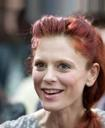
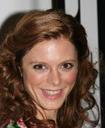
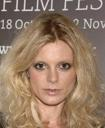
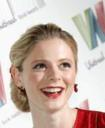
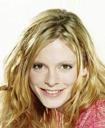
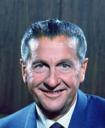
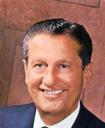
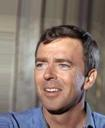
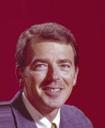
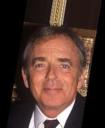

In [33]:
from domino.emb.bit import embed_images
embed_images.out().load()

In [18]:
from domino.evaluate import run_sdm
run_sdm(**run_sdm.inp())

task: run_sdm, run_id=22416
Creating slice discovery method...
Loading embeddings...


  0%|          | 0/1000 [00:00<?, ?it/s]

Fitting slice discovery method...


100%|██████████| 1000/1000 [00:19<00:00, 51.30it/s]


Transforming slice discovery method...
Explaining slices...


[Artifact(id=246550, run_id=22416, type=<class 'meerkat.datapanel.DataPanel'>),
 Artifact(id=246551, run_id=22416, type=<class 'meerkat.datapanel.DataPanel'>)]

In [15]:
run_sdm.inp()["data_dp"].load()["probs"]

,(TensorColumn)
0,torch.Tensor(shape=torch.Size([2]))
1,torch.Tensor(shape=torch.Size([2]))
2,torch.Tensor(shape=torch.Size([2]))
3,torch.Tensor(shape=torch.Size([2]))
4,torch.Tensor(shape=torch.Size([2]))
...,...
29994,torch.Tensor(shape=torch.Size([2]))
29995,torch.Tensor(shape=torch.Size([2]))
29996,torch.Tensor(shape=torch.Size([2]))
29997,torch.Tensor(shape=torch.Size([2]))


In [16]:
run_sdm.inp()["data_dp"].load()["target"]

,(NumpyArrayColumn)
0,0.0
1,1.0
2,1.0
3,1.0
4,0.0
...,...
29994,0.0
29995,1.0
29996,0.0
29997,0.0


In [27]:
run_sdm.inp()

{'data_dp': Artifact(id=231243, run_id=19395, type=<class 'meerkat.datapanel.DataPanel'>),
 'emb_dp': Artifact(id=231041, run_id=19192, type=<class 'meerkat.datapanel.DataPanel'>),
 'xmodal_emb_dp': Artifact(id=231045, run_id=19196, type=<class 'meerkat.datapanel.DataPanel'>),
 'model': None,
 'id_column': 'image_id',
 'word_dp': Artifact(id=225672, run_id=18284, type=<class 'meerkat.datapanel.DataPanel'>),
 'sdm_class': domino.sdm.spotlight.SpotlightSDM,
 'sdm_config': {'learning_rate': 0.001,
  'n_slices': 1,
  'emb': 'body',
  'xmodal_emb': 'emb'},
 'setting_id': 'e05cf483-a95d-4d8a-a0a0-6ce4e34937d0',
 'build_setting_run_id': Artifact(id=260736, run_id=24789, type=<class 'numpy.int64'>),
 'score_model_run_id': Artifact(id=260737, run_id=24789, type=<class 'numpy.int64'>),
 'score_settings_run_id': Artifact(id=260738, run_id=24789, type=<class 'numpy.int64'>),
 'synthetic_preds': Artifact(id=260739, run_id=24789, type=<class 'numpy.bool_'>),
 'index': '393',
 'alpha': 0.029999999999

In [28]:
"hel" in "hello"

True

In [31]:
terra.inp(25659)["sdm_class"]

domino.sdm.spotlight.SpotlightSDM

In [53]:
log = run_sdms.get_log()

In [50]:
log.find("end of loop")

167810

In [52]:
log[167810:]

"Retrying terra database commit (0/10).\n[2021-09-26 06:02:20.170960]: \x1b\x1b(ImplicitFunc pid=231)\x1b Retrying terra database commit (0/10).\n[2021-09-26 06:02:20.384720]: \x1b\x1b(ImplicitFunc pid=234)\x1b task: run_sdm, run_id=25890\n[2021-09-26 06:02:20.486869]: \x1b\x1b(ImplicitFunc pid=192)\x1b task: run_sdm, run_id=25923\n[2021-09-26 06:02:20.700582]: \x1b\x1b(ImplicitFunc pid=235)\x1b task: run_sdm, run_id=25887\n[2021-09-26 06:02:20.700678]: \x1b\x1b(ImplicitFunc pid=183)\x1b task: run_sdm, run_id=25922\n[2021-09-26 06:02:20.904203]: \x1b\x1b(ImplicitFunc pid=236)\x1b task: run_sdm, run_id=25881\n[2021-09-26 06:02:21.016377]: \x1b\x1b(ImplicitFunc pid=184)\x1b Retrying terra database commit (0/10).\n[2021-09-26 06:02:21.016460]: \x1b\x1b(ImplicitFunc pid=174)\x1b task: run_sdm, run_id=25905\n[2021-09-26 06:02:21.231271]: \x1b\x1b(ImplicitFunc pid=182)\x1b Retrying terra database commit (0/10).\n[2021-09-26 06:02:21.333166]: \x1b\x1b(ImplicitFunc pid=203)\x1b Retrying terra 